# fm0 iq decode
Actually trying to decode the FM0 from a recording.

Close range, high power, just the access code so far.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import itertools as it

from collections import Counter
from enum import Enum

In [3]:
FILE = "/Users/ebaum/Documents/capstone/iq/mag-with-blips-30k.iq"

SPS = 32
SAMP_RATE = 30e3

class Pulse(Enum):
    SHORT_PULSE  = SPS
    LONG_PULSE   = 2 * SPS
    MID_POINT    = (SHORT_PULSE + LONG_PULSE) // 2
    NOISE_FACTOR = 0.5
    NOISE_PULSE  = SHORT_PULSE * NOISE_FACTOR

data = np.fromfile(FILE, dtype=np.float32)
bin_data = np.sign(data) / 2  # maybe later - soft decisions
print(f"loaded {len(data)} samples -> {len(data) / SAMP_RATE:.2f} sec")

loaded 2245700 samples -> 74.86 sec


In [4]:
pulse_len = np.diff(np.where(np.diff(bin_data) != 0)[0])

def find_pulses(raw_pulse):
    # this will return offset by one
    last = 0
    bit_iter = iter(raw_pulse)
    for p in bit_iter:
        if p < Pulse.NOISE_PULSE.value:
            # print("noise")
            last += p + next(bit_iter)
            continue
        else:
            if last < Pulse.MID_POINT.value:
                yield Pulse.SHORT_PULSE.value
            else:
                yield Pulse.LONG_PULSE.value
        last = p
        
def convert_symbols(clean_pulse):
    n = 0
    pulse_iter = iter(clean_pulse)
    for p in pulse_iter:
        if p == Pulse.SHORT_PULSE.value:
            try:
                p = next(pulse_iter)
            except StopIteration:
                break
            if p == Pulse.SHORT_PULSE.value:
                # short short
                yield 0
            else:
                # short long shoulnd't happen, lost sync.
                # print("sync", n)
                # yield 0?
                yield 1
        elif p == Pulse.LONG_PULSE.value:
            yield 1
        n += 1

clean_pulse = list(find_pulses(pulse_len))
symbols = list(convert_symbols(clean_pulse))

<IPython.core.display.Javascript object>


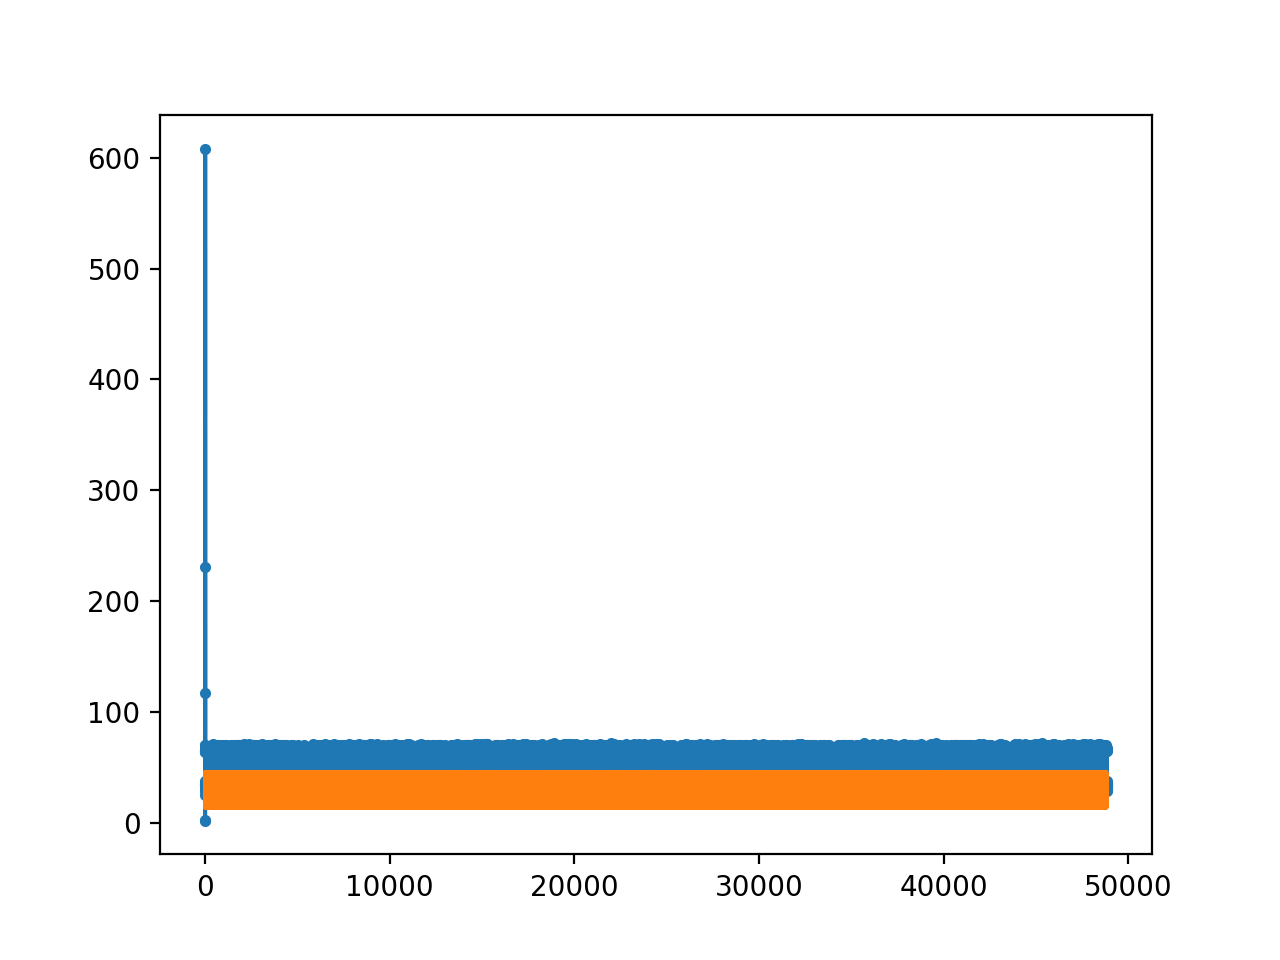

In [5]:
%matplotlib notebook
plt.plot(pulse_len, '.-')
plt.plot(np.array(clean_pulse)[10:] - 18, '--')
# plt.xlim(20000, 20100)
# plt.hlines(Pulse.NOISE_PULSE.value, 0, 11000)

<IPython.core.display.Javascript object>


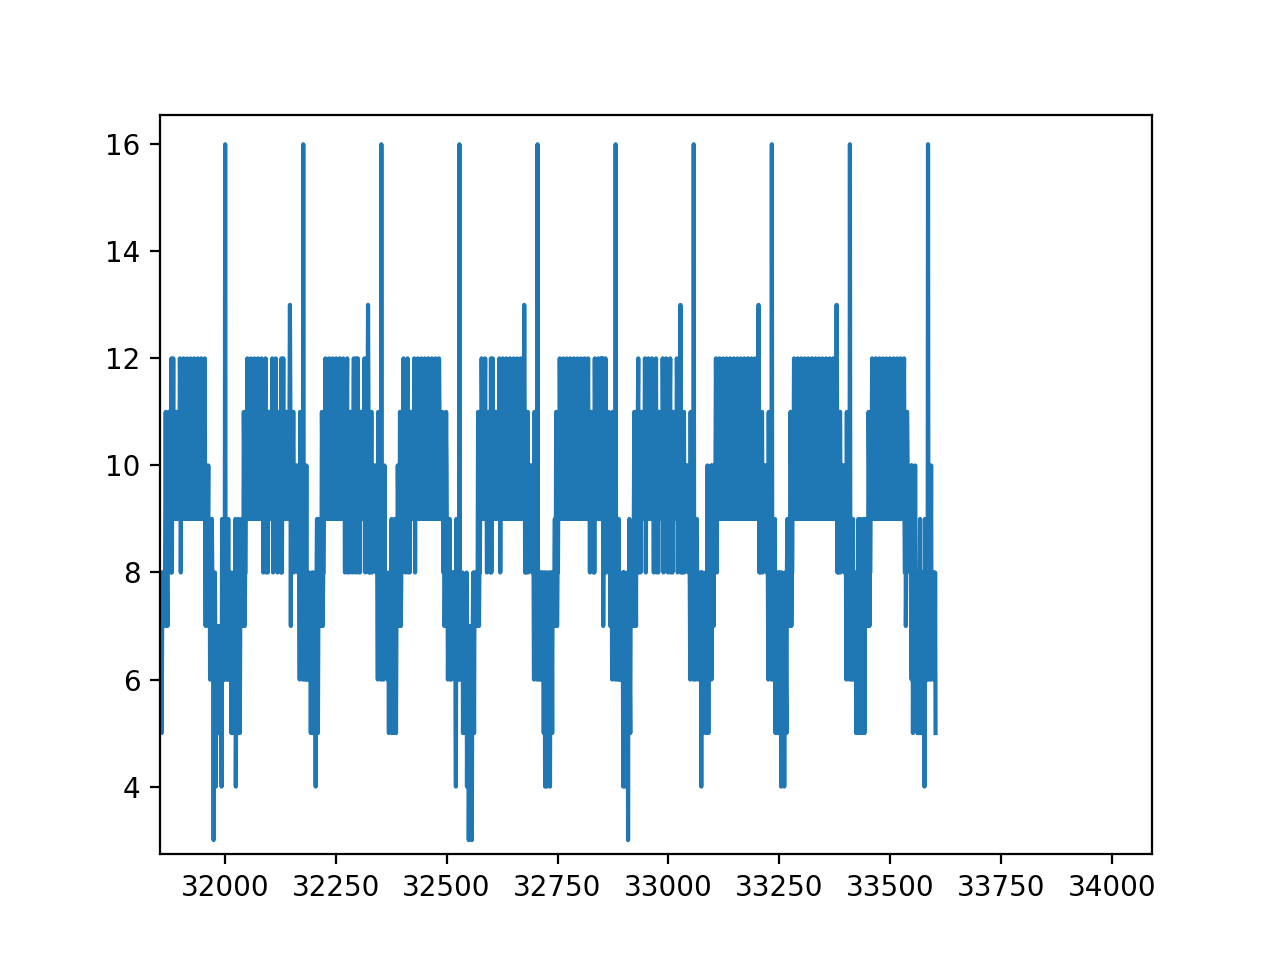

In [6]:
# arbitrary for now
CORR_LIMIT = 15

# ACCESS_CODE = 0xe15ae893
ACCESS_CODE = 0xe15ae893
ac_arr = np.array(list(map(int, bin(ACCESS_CODE)[2:])))

corr = np.correlate(np.array(symbols), ac_arr)
ac_loc = np.where(corr == np.max(corr))[0]

for L in ac_loc:
    ac = hex(int(''.join(map(str, symbols[L:L+len(ac_arr)])), 2))
#     print(f"{L:5} {ac}")

plt.figure()
plt.plot(corr)

In [10]:
def binlist2num(b):
    return int(''.join(map(str, b)), 2)

def parsebytelist(b):
    while b:
        byte = list(it.islice(b, 8))
        
        if not byte:
            break
            
        yield binlist2num(byte)

bit_iter = iter(symbols)

corr = np.correlate(np.array(symbols), ac_arr)
packet_starts = np.where(corr >= 16)[0]

sensor_data = []

last_sqn = None

i = 0

while i < len(symbols):
    corr = np.correlate(symbols[i:i+len(ac_arr)], ac_arr)[0]
#     print(i, corr)
    if corr < 16:
        print(hex(binlist2num(symbols[i:i+len(ac_arr)])))
        i += 1
        continue
    
    bit_iter = iter(symbols[i:])
    access_code = binlist2num(it.islice(bit_iter, 32))
    sqn = binlist2num(it.islice(bit_iter, 8))
    pkt_len = binlist2num(it.islice(bit_iter, 8))
    
    data = list(parsebytelist(it.islice(bit_iter, pkt_len * 8)))

    if last_sqn is not None and (last_sqn + 1) & 0xFF != sqn:
        sqn_str = 'ERR'
        sensor_data.extend([-10]) # just for viz purposes
        data = None
        i += 1 # no dice here - so we want to check the next bit
    else:
        sqn_str = 'OK'
        sensor_data.extend(data)
        i += 32 + 8 * 2 + pkt_len * 8 # this worked out - so skip to the next packet!
    
    print(f"{i} {access_code:x} {sqn=:x} {sqn_str:3} {pkt_len=} {data}")
    
    
    last_sqn = sqn

# plt.figure()
# plt.plot(np.correlate(np.array(symbols), ac_arr))

0xe9e7883a
0xd3cf1075
0xa79e20ea
0x4f3c41d5
0x9e7883ab
0x3cf10757
0x79e20eae
0xf3c41d5d
0xe7883aba
0xcf107575
0x9e20eaea
0x3c41d5d5
0x7883abab
0xf1075757
0xe20eaeae
0xc41d5d5d
0x883ababa
0x10757575
0x20eaeaea
0x41d5d5d5
0x83ababab
0x7575757
0xeaeaeae
0x1d5d5d5d
0x3abababa
0x75757575
0xeaeaeaea
0xd5d5d5d5
0xabababab
0x57575757
0xaeaeaeae
0x5d5d5d5d
0xbabababa
0x75757575
0xeaeaeaea
0xd5d5d5d5
0xabababab
0x57575757
0xaeaeaeae
0x5d5d5d5d
0xbabababa
0x75757575
0xeaeaeaea
0xd5d5d5d5
0xabababab
0x57575757
0xaeaeaeae
0x5d5d5d5d
0xbabababa
0x75757575
0xeaeaeaea
0xd5d5d5d5
0xabababab
0x57575757
0xaeaeaeae
0x5d5d5d5d
0xbabababa
0x75757575
0xeaeaeaea
0xd5d5d5d5
0xabababab
0x57575757
0xaeaeaeae
0x5d5d5d5d
0xbabababa
0x75757575
0xeaeaeaea
0xd5d5d5d5
0xabababab
0x57575757
0xaeaeaeae
0x5d5d5d5d
0xbabababa
0x75757575
0xeaeaeaea
0xd5d5d5d5
0xabababab
0x57575757
0xaeaeaeae
0x5d5d5d5d
0xbabababa
0x75757575
0xeaeaeaea
0xd5d5d5d5
0xabababab
0x57575757
0xaeaeaeae
0x5d5d5d5d
0xbabababa
0x75757575
0xeaeaeaea
0

0x15ae8935
0x2b5d126b
0x56ba24d6
0xad7449ad
0x5ae8935a
0xb5d126b4
0x6ba24d68
0xd7449ad0
0xae8935a1
0x5d126b42
0xba24d684
0x7449ad08
0xe8935a10
0xd126b420
0xa24d6841
0x449ad083
0x8935a107
0x126b420e
0x24d6841d
0x49ad083b
0x935a1076
0x26b420ec
0x4d6841d9
0x9ad083b3
0x35a10767
0x6b420ece
0xd6841d9d
0xad083b3b
0x5a107676
0xb420ecec
0x6841d9d9
0xd083b3b3
0xa1076767
0x420ecece
0x841d9d9d
0x83b3b3b
0x10767676
0x20ececec
0x41d9d9d9
0x83b3b3b3
0x7676767
0xececece
0x1d9d9d9d
0x3b3b3b3b
0x76767676
0xecececec
0xd9d9d9d9
0xb3b3b3b3
0x67676767
0xcececece
0x9d9d9d9d
0x3b3b3b3a
0x76767675
0xecececea
0xd9d9d9d5
0xb3b3b3ab
0x67676757
0xcececeae
0x9d9d9d5d
0x3b3b3abb
0x76767576
0xececeaec
0xd9d9d5d9
0xb3b3abb3
0x67675767
0xceceaece
0x9d9d5d9d
0x3b3abb3a
0x76757675
0xeceaecea
0xd9d5d9d5
0xb3abb3ab
0x67576757
0xceaeceae
0x9d5d9d5d
0x3abb3abb
0x75767576
0xeaeceaec
0xd5d9d5d9
0xabb3abb3
0x57675767
0xaeceaece
0x5d9d5d9d
0xbb3abb3a
0x76757675
0xeceaecea
0xd9d5d9d5
0xb3abb3ab
0x67576757
0xceaeceae
0x9d5d9d5d
0x

0xb3b3b3b3
0x67676767
0xcececece
0x9d9d9d9d
0x3b3b3b3b
0x76767676
0xecececec
0xd9d9d9d9
0xb3b3b3b3
0x67676767
0xcececece
0x9d9d9d9d
0x3b3b3b3b
0x76767676
0xecececec
0xd9d9d9d9
0xb3b3b3b3
0x67676767
0xcececece
0x9d9d9d9d
0x3b3b3b3b
0x76767676
0xecececec
0xd9d9d9d9
0xb3b3b3b3
0x67676767
0xcececece
0x9d9d9d9d
0x3b3b3b3b
0x76767676
0xecececec
0xd9d9d9d9
0xb3b3b3b3
0x67676767
0xcececece
0x9d9d9d9d
0x3b3b3b3b
0x76767676
0xecececec
0xd9d9d9d9
0xb3b3b3b3
0x67676767
0xcececece
0x9d9d9d9d
0x3b3b3b3b
0x76767676
0xecececec
0xd9d9d9d9
0xb3b3b3b3
0x67676767
0xcececece
0x9d9d9d9d
0x3b3b3b3a
0x76767675
0xecececeb
0xd9d9d9d7
0xb3b3b3af
0x6767675e
0xcececebc
0x9d9d9d78
0x3b3b3af0
0x767675e1
0xececebc2
0xd9d9d785
0xb3b3af0a
0x67675e15
0xcecebc2b
0x9d9d7856
0x3b3af0ad
0x7675e15a
0xecebc2b5
0xd9d7856b
0xb3af0ad7
0x675e15ae
0xcebc2b5d
0x9d7856ba
0x3af0ad74
0x75e15ae8
0xebc2b5d1
0xd7856ba2
0xaf0ad744
0x5e15ae89
0xbc2b5d12
0x7856ba24
0xf0ad7449
26897 e15ae893 sqn=67 OK  pkt_len=16 [118, 118, 118, 118, 118, 11

<IPython.core.display.Javascript object>


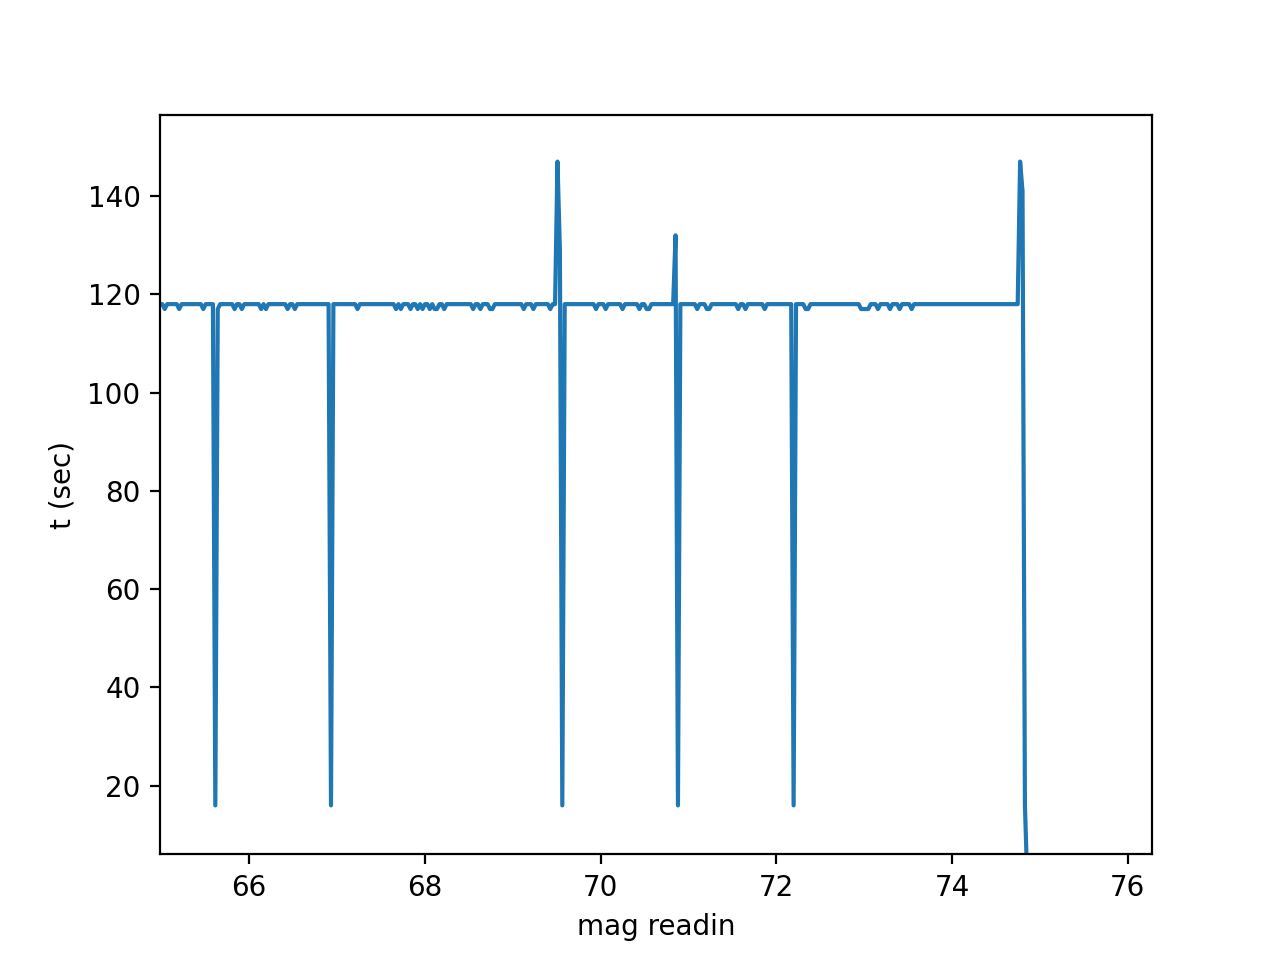

Text(0.5, 0, 'mag readin')

In [8]:
plt.figure()
# this is slightly inexact because of packet headers but whatever
t = np.linspace(0, len(bin_data) / 30e3, len(sensor_data))
plt.plot(t, sensor_data)
plt.ylim(-10, 251)
plt.ylabel('t (sec)')
plt.xlabel('mag readin')

In [335]:
len(symbols)/len(sensor_data)

8.876550868486353